In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')#loading the data

In [3]:
data.head(2)

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


In [4]:
data.describe()#describing numerical columns

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,7335.000000
mean,33.940704,-117.893072,1352.380350,10.834250,1129.599200,1.418150,30.135000,297.176950,366.405044
std,2.126810,7.377726,646.100291,6.033166,603.330519,0.493267,21.863645,212.007298,120.485687
min,0.000000,-118.663400,1.000000,1.000000,101.000000,1.000000,-2.000000,101.000000,101.000000
25%,34.009200,-118.429700,930.000000,6.000000,632.000000,1.000000,12.000000,101.000000,312.000000
50%,34.058700,-118.323000,1430.000000,11.000000,1162.000000,1.000000,31.000000,203.000000,400.000000
75%,34.165025,-118.274400,1900.000000,16.000000,1622.000000,2.000000,46.000000,501.000000,400.000000
max,34.328100,0.000000,2359.000000,21.000000,2197.000000,2.000000,99.000000,969.000000,515.000000


**Insights**

Victim_Age minimum value is -2 which should not be the case.

In [5]:
data['Victim_Age'].replace(-2,0,inplace=True)#replacing -2 to handel wrong value

In [6]:
categorical_cols=data.select_dtypes('object')
for cols in categorical_cols:
    print(data[cols].describe())#describing all the categorical columns

count     20000
unique    12399
top         6TH
freq         33
Name: Location, dtype: object
count         3448
unique        1495
top       BROADWAY
freq            56
Name: Cross_Street, dtype: object
count                      20000
unique                       811
top       07/13/2020 12:00:00 AM
freq                          87
Name: Date_Reported, dtype: object
count                      20000
unique                       366
top       01/01/2020 12:00:00 AM
freq                         137
Name: Date_Occurred, dtype: object
count           20000
unique             21
top       77th Street
freq             1345
Name: Area_Name, dtype: object
count     17259
unique    10489
top        0344
freq        826
Name: Modus_Operandi, dtype: object
count     17376
unique        4
top           M
freq       8538
Name: Victim_Sex, dtype: object
count     17376
unique       17
top           H
freq       6143
Name: Victim_Descent, dtype: object
count      19995
unique       216
top       STR

**Insights**
Status_Description and status is similar

# Feature Engineering

# Conversion of feature date_Occurred,Time_Ocurred and date_reported to month,week and hour on data

Week days ,Month gives better understanding that complete date and date usually not supported by models

In [7]:
def process_dates(data_e,date_column): 
    data[date_column]= pd.to_datetime(data[date_column])
    data[f'{date_column}_month'] = data[date_column].dt.month
    data[f'{date_column}_dayofweek'] = data[date_column].dt.dayofweek
    data[f'{date_column}_dayofmonth'] = data[date_column].dt.day
    return data

In [8]:
data = process_dates(data, 'Date_Reported')

In [9]:
data.drop(columns=['Date_Reported'],inplace=True)

In [10]:
data = process_dates(data, 'Date_Occurred')

In [11]:
data.drop(columns=['Date_Occurred'],inplace=True)

# Conversion of feature Time_Occurred to hour

Seconds increase distinct category which makes thus we take only hour.It makes data more relatable.

In [12]:
def convertingtohour(time):#taking only starting two digits
    return str(time)[:-4]
    

In [13]:
dt=pd.DataFrame()
dt['Time_Occurred']=data['Time_Occurred'].copy()
dt['hour']=(dt['Time_Occurred'].apply(convertingtohour))
dt=dt.drop(columns=['Time_Occurred'])


In [14]:
data.drop(columns=['Time_Occurred'],inplace=True)

In [15]:
data = pd.concat([data,dt],axis=1)

In [16]:
data['hour'].value_counts()

hour
12    1463
17    1213
18    1193
19    1166
20    1131
21    1104
15    1049
16    1027
14    1012
22     950
13     919
10     877
11     841
       819
23     818
8      736
9      666
1      554
2      494
7      471
3      431
6      403
5      345
4      318
Name: count, dtype: int64

In [17]:
data['hour'].replace('',0,inplace=True)#handling missing values

In [18]:
data['hour']=data['hour'].astype(int)#converting type

In [19]:
data.isnull().sum()
pd.set_option('display.max_columns', None)
data.shape

(20000, 26)

Binning Age - Decreases distinct values

In [20]:
data['Victim_Age']=pd.cut(data['Victim_Age'],bins=(0,10,20,30,40,50,60,float('inf')),labels=['10','20','30','40','50','60','70'])

Split Location column and takes only last word which is ST,AX etc ,it decreases number of distinct category and make it more correlated with target.

In [21]:
def extract_last_word(address): #last word have less distinct
    parts=address.split()
    return parts[-1]

In [22]:
data['Location']=data['Location'].apply(extract_last_word)

In [23]:
y = data['Crime_Category']
X = data.drop(columns=['Premise_Description','Status','Latitude','Longitude','Crime_Category','Area_ID','Cross_Street','Weapon_Description'])

**Reason for droping each column**
* Premise_Description - Premise_code gives the same information
* 'Status - Status_Description gives same information
* Latitude&Longitude - Location gives same information
* Crime_Category is the target column
* Area_ID -Reporting_district gives same info
* Cross_street - data has only nan values mostly
* Weapon-description is same as weapon used code


In [24]:
lencoder=LabelEncoder()
y=lencoder.fit_transform(y)
elements,count=np.unique(y,return_counts=True)
elements,count

(array([0, 1, 2, 3, 4, 5]), array([  225,  1808,  1355,   179, 11666,  4767]))

Select_k_best ,LGBM are not supporting categorical column fitting


# Imputation -cleaning data

In [25]:
X.isnull().sum()

Location                        0
Area_Name                       0
Reporting_District_no           0
Part 1-2                        0
Modus_Operandi               2741
Victim_Age                   4834
Victim_Sex                   2624
Victim_Descent               2624
Premise_Code                    0
Weapon_Used_Code            12665
Status_Description              0
Date_Reported_month             0
Date_Reported_dayofweek         0
Date_Reported_dayofmonth        0
Date_Occurred_month             0
Date_Occurred_dayofweek         0
Date_Occurred_dayofmonth        0
hour                            0
dtype: int64

In [26]:
cat_cols=X.select_dtypes(include='object')
num_cols=X.select_dtypes(exclude='object')
cat_cols

,Location,Area_Name,Modus_Operandi,Victim_Sex,Victim_Descent,Status_Description
0,AV,N Hollywood,0385,M,W,Invest Cont
1,ST,Newton,0906 0352 0371 0446 1822 0344 0416 0417,M,H,Invest Cont
2,BL,Newton,0329 1202,M,B,Invest Cont
3,ST,Mission,0329 1300,M,H,Invest Cont
4,AV,77th Street,0416 0945 1822 0400 0417 0344,X,X,Invest Cont
...,...,...,...,...,...,...
19995,BL,Southwest,0416 0446 2004 0913,M,H,Invest Cont
19996,BL,West Valley,1822 0209 0344 1414 1420,M,W,Invest Cont
19997,ST,West LA,0344 1822 1420,M,H,Invest Cont
19998,ST,Harbor,1202 2038 0913 0602 1242 0553,F,H,Invest Cont


In [27]:
transform=ColumnTransformer([('num_cols',SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0),num_cols.columns),
                            ('cat_cols',SimpleImputer(missing_values=np.nan,strategy='constant',fill_value='v_null'),cat_cols.columns)],verbose_feature_names_out=False).set_output(transform=('pandas'))
X_clean=transform.fit_transform(X,y)
#fill values with 0 and v_null so that not much baise form

# EDA

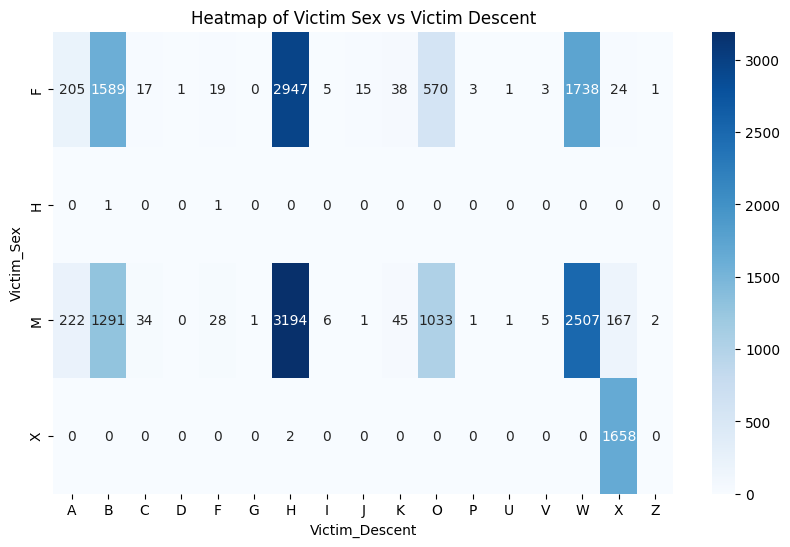

In [28]:
crosstab = pd.crosstab(data['Victim_Sex'], data['Victim_Descent'])

# Plot as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab, annot=True, fmt='g', cmap='Blues')  
plt.title('Heatmap of Victim Sex vs Victim Descent')
plt.show()

**Insights**

H descent has maximum male and female

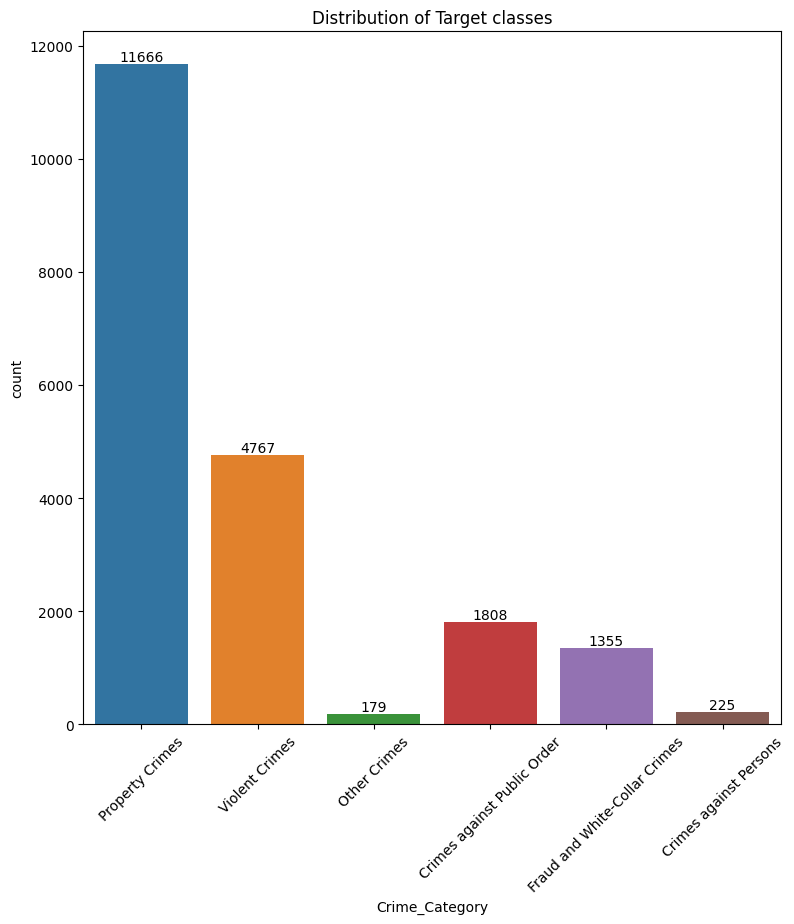

In [109]:
plt.figure(figsize=(9,9))
ax=sns.countplot(x='Crime_Category', data=data)
plt.xticks(rotation=45, fontsize=10)
plt.title('Distribution of Target classes')
for p in ax.patches:
    height = p.get_height()  
    # .0f' for no decimals
    ax.annotate(format(height, '.0f'),  # Label text (count of occurrences)
                (p.get_x() + p.get_width() / 2., height),  # Position the label
                ha='center', va='center',  # Center alignment
                xytext=(0, 5), textcoords='offset points')  # Offset the label above the bar

plt.show()

**Insights**

* The graph shows that data has multiclass target ,hence need to focus on solving multiclass proble problem
* The graph shows that the data is imbalance hence we need to use ensembel model which combines prediction of different models (often called as weak learners) to give a single robust and balanced predictions.They can provide better prediction and gernalize better.
* I tried many Boosting techniques as they have scale_pos_weight parameter which is by default one and treats imbalance data well.


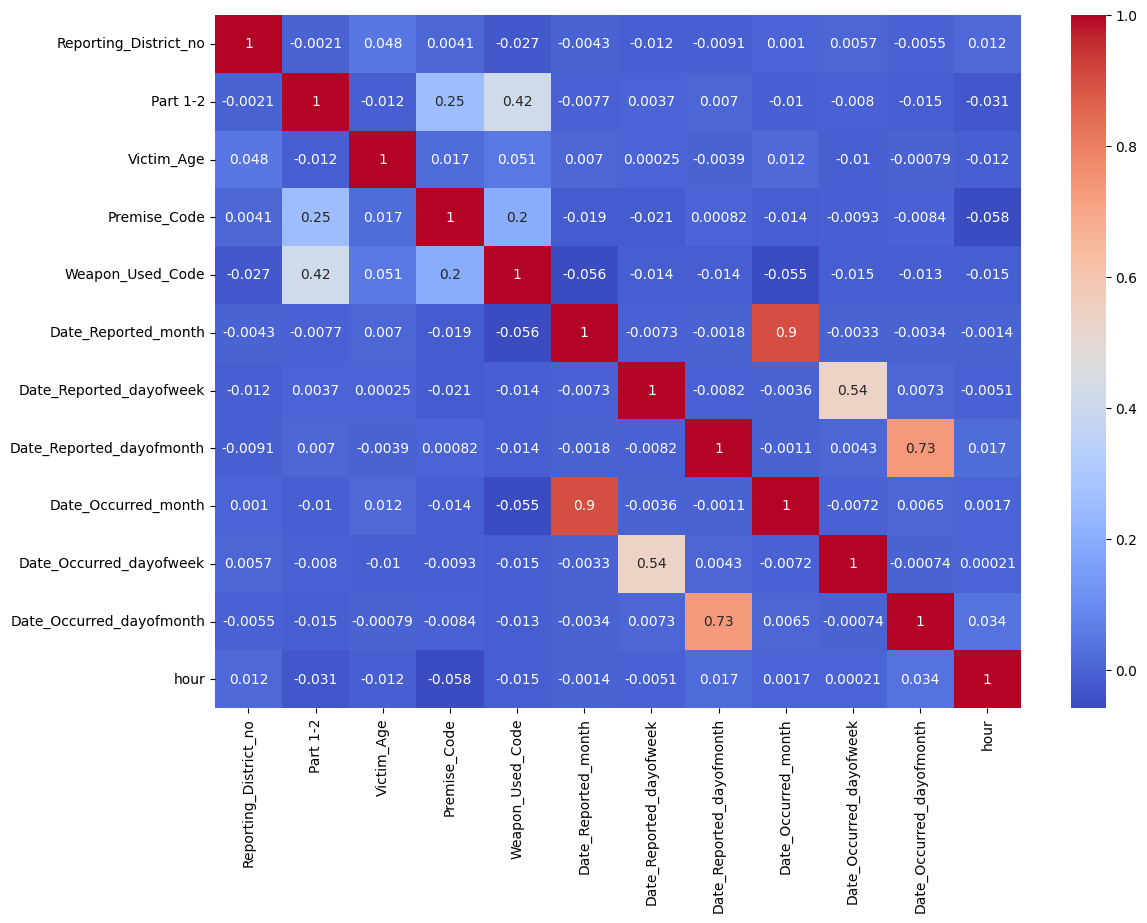

In [123]:
plt.figure(figsize = (13,9))
sns.heatmap(num_cols.corr(), annot =  True, cmap = 'coolwarm') 
plt.show()


**Insights**
* Area_ID & Reporting_District_no are highly correlated
* month_o & month of date_reported is almost same
* part 1,2 & weapon used code are related
* So we droped Area_ID  according to insights


In [118]:
print(type(y))

<class 'numpy.ndarray'>


In [120]:
if not isinstance(y, pd.Series):
    y = pd.Series(y)

# Display the type of y to confirm
print(type(y))

<class 'pandas.core.series.Series'>


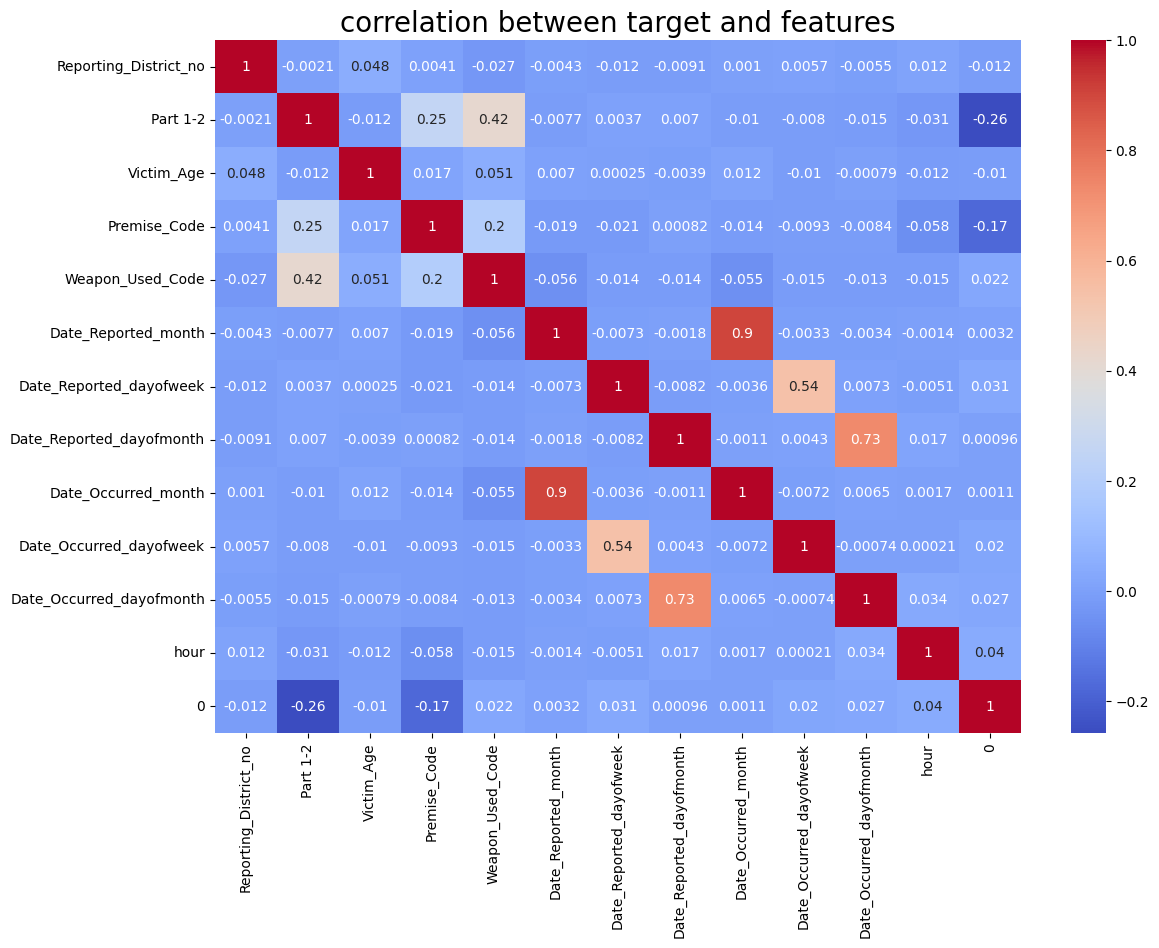

In [122]:
num_cols_=pd.concat([num_cols,y],axis=1)
plt.figure(figsize = (13,9))
sns.heatmap(num_cols_.corr(), annot =  True, cmap = 'coolwarm')
plt.title('correlation between target and features',fontsize=20,fontname='Times New Roman')
plt.show()


**Insights**
* Part 12 are highly related to crimecategory
* Premise code and weekday on which incident occured are more related to target feature then all other features,except Part12




In [ ]:
y.to_numpy()

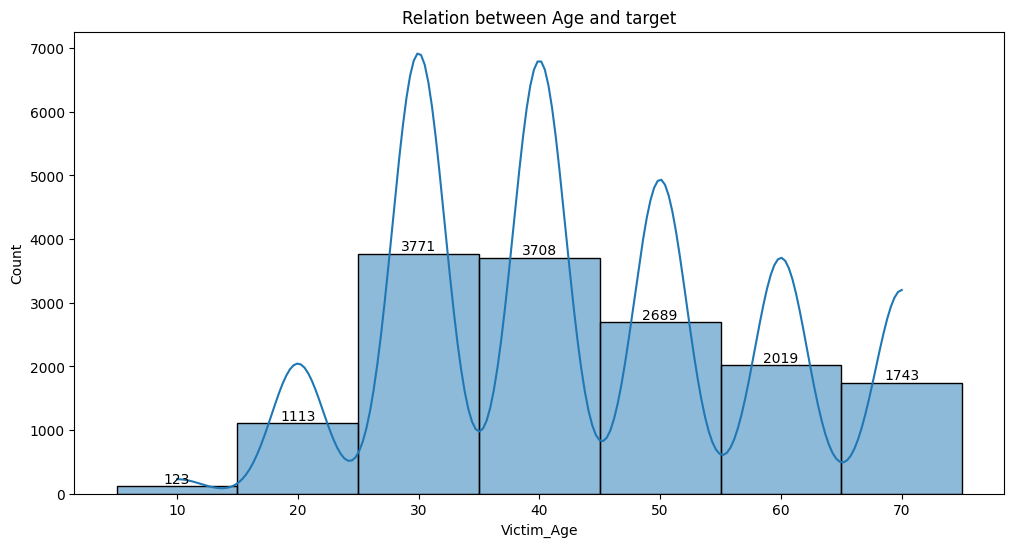

In [116]:
plt.figure(figsize=(12,6))

ax=sns.histplot(x=data['Victim_Age'],kde=True)#kde=True helps in forming curve which represent density of data points
plt.title('Relation between Age and target')
for p in ax.patches:
    height = p.get_height()  # Get the height of the bar (count)
    # Use '.2f' to format floats to 2 decimal places, or change to '.0f' for no decimals
    ax.annotate(format(height, '.0f'),  # Label text (count of occurrences)
                (p.get_x() + p.get_width() / 2., height),  # Position the label
                ha='center', va='center',  # Center alignment
                xytext=(0, 5), textcoords='offset points')  
plt.show()

**Insights**
* crime are happening more with young age people this mght be because young population is more

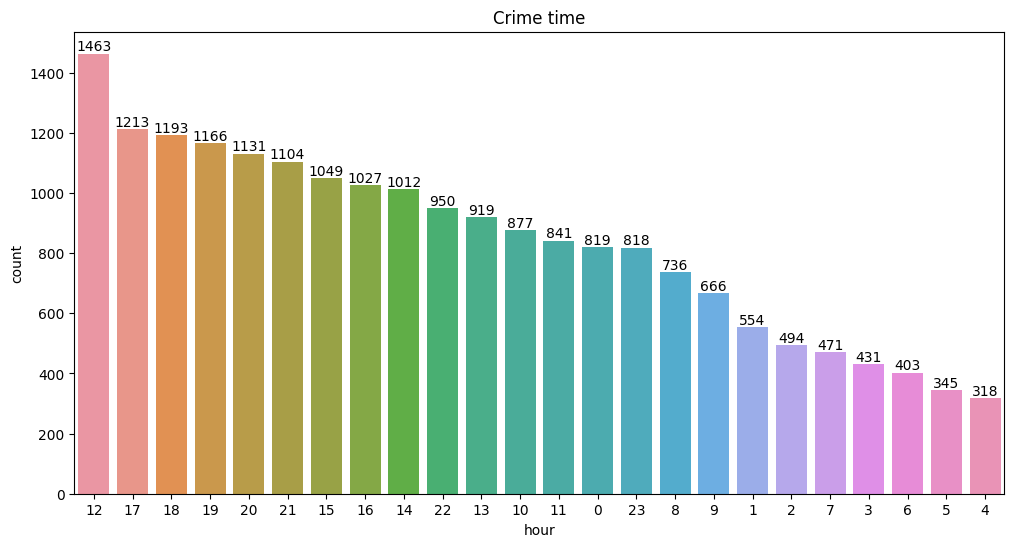

In [35]:
plt.figure(figsize=(12,6))
counts = data['hour'].value_counts().sort_values(ascending=False)
ax=sns.countplot(x=data['hour'],data=data,order=counts.index)
plt.title('Crime time')
for p in ax.patches:
    height = p.get_height()  # Get the height of the bar (count)
    # Use '.2f' to format floats to 2 decimal places, or change to '.0f' for no decimals
    ax.annotate(format(height, '.0f'),  # Label text (count of occurrences)
                (p.get_x() + p.get_width() / 2., height),  # Position the label
                ha='center', va='center',  # Center alignment
                xytext=(0, 5), textcoords='offset points')  
plt.show()

**Insights**
* crimes mostly happen at noon

**crimes_category_distribution**

* label count   category
* 4    11666  Property crimes
* 5     4767  violent crimes
* 1     1808  crimes against publiv order
* 2     1355  fraud and white coller crimes
* 0      225  crimes against person
* 3      179  other crimes

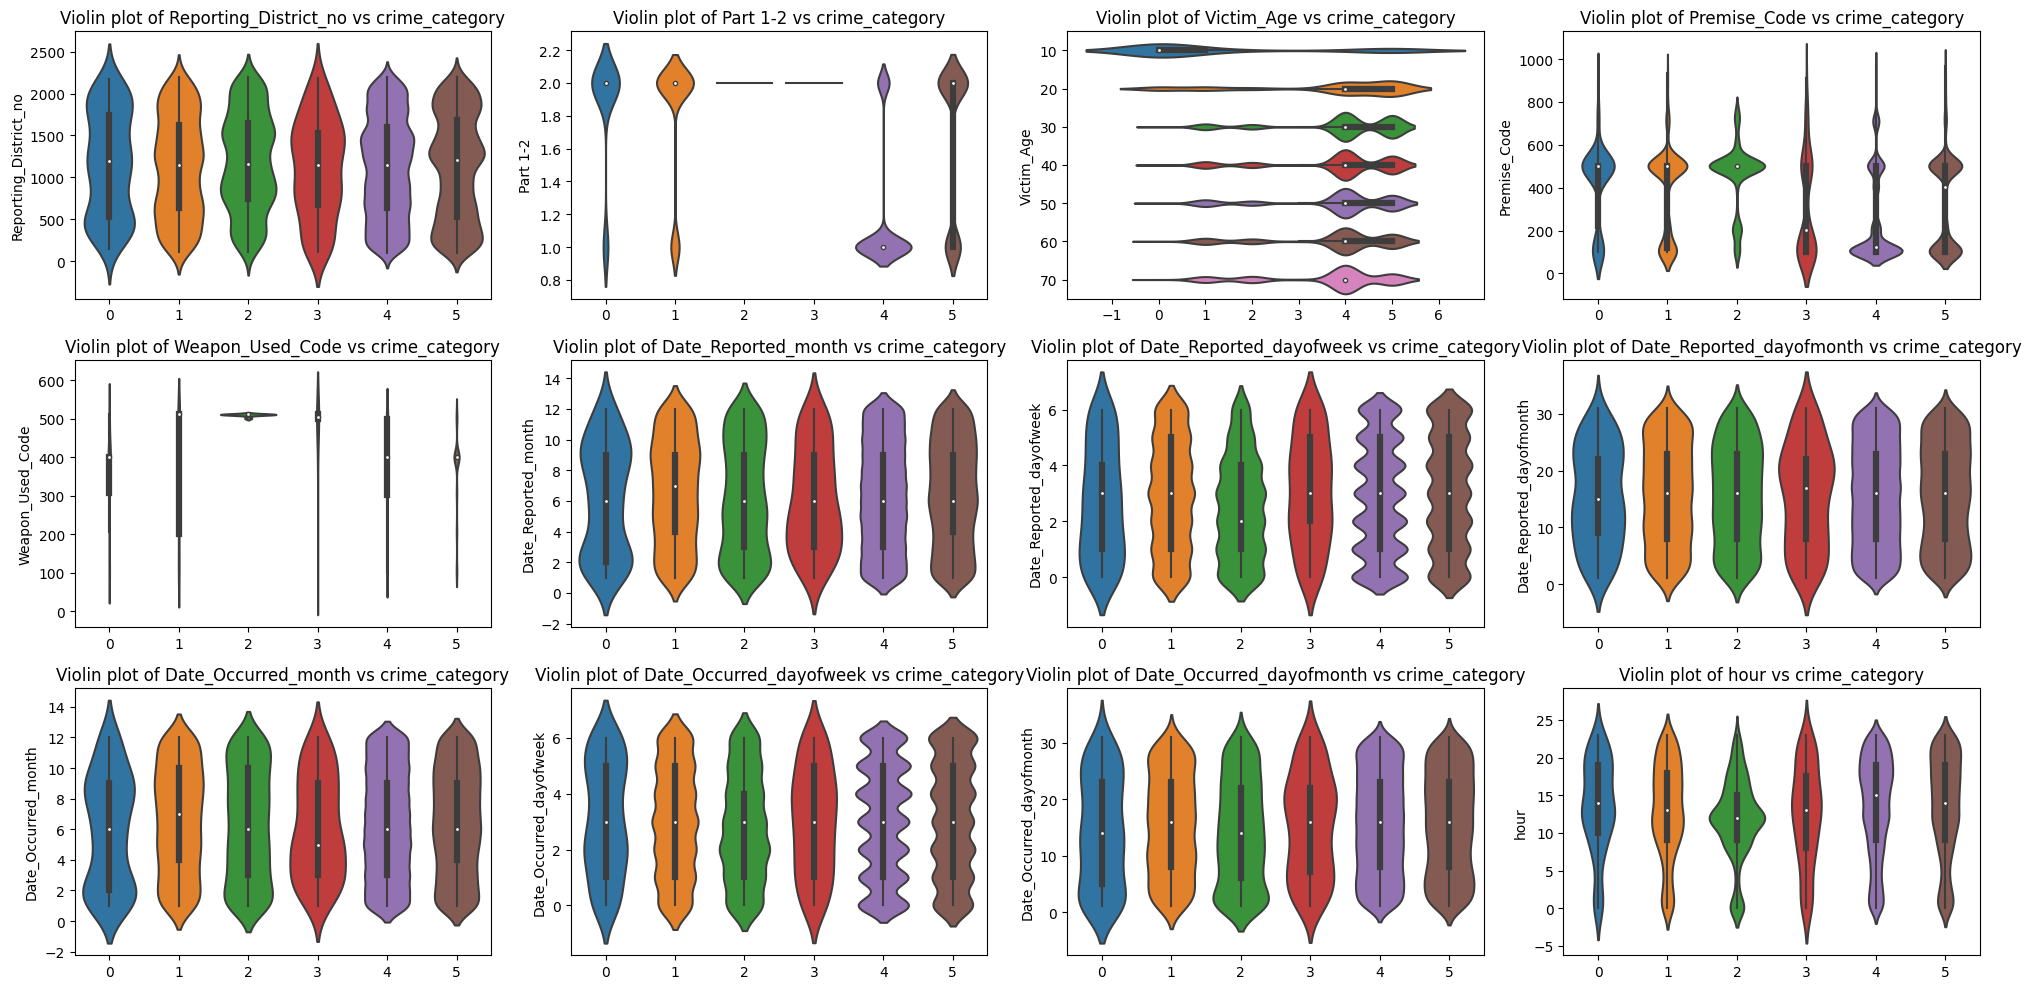

In [36]:
plt.figure(figsize=(20, 10))

columns = num_cols.columns
num_cols_length = len(columns)
rows = (num_cols_length + 3) // 4  # Calculate rows needed with 4 plots per row

for i in range(num_cols_length):
    plt.subplot(rows, 4, i + 1)
    sns.violinplot(x=y, y=data[columns[i]], data=data)
    plt.title(f'Violin plot of {columns[i]} vs crime_category')

plt.tight_layout()
plt.show()


**crimes_category_distribution**

* label count   category
* 4    11666  Property crimes
* 5     4767  violent crimes
* 1     1808  crimes against publiv order
* 2     1355  fraud and white coller crimes
* 0      225  crimes against person
* 3      179  other crimes

**Insights**
* for second and hird there is only 2  value in part12
* between 400-600 most of the value belong in premise code


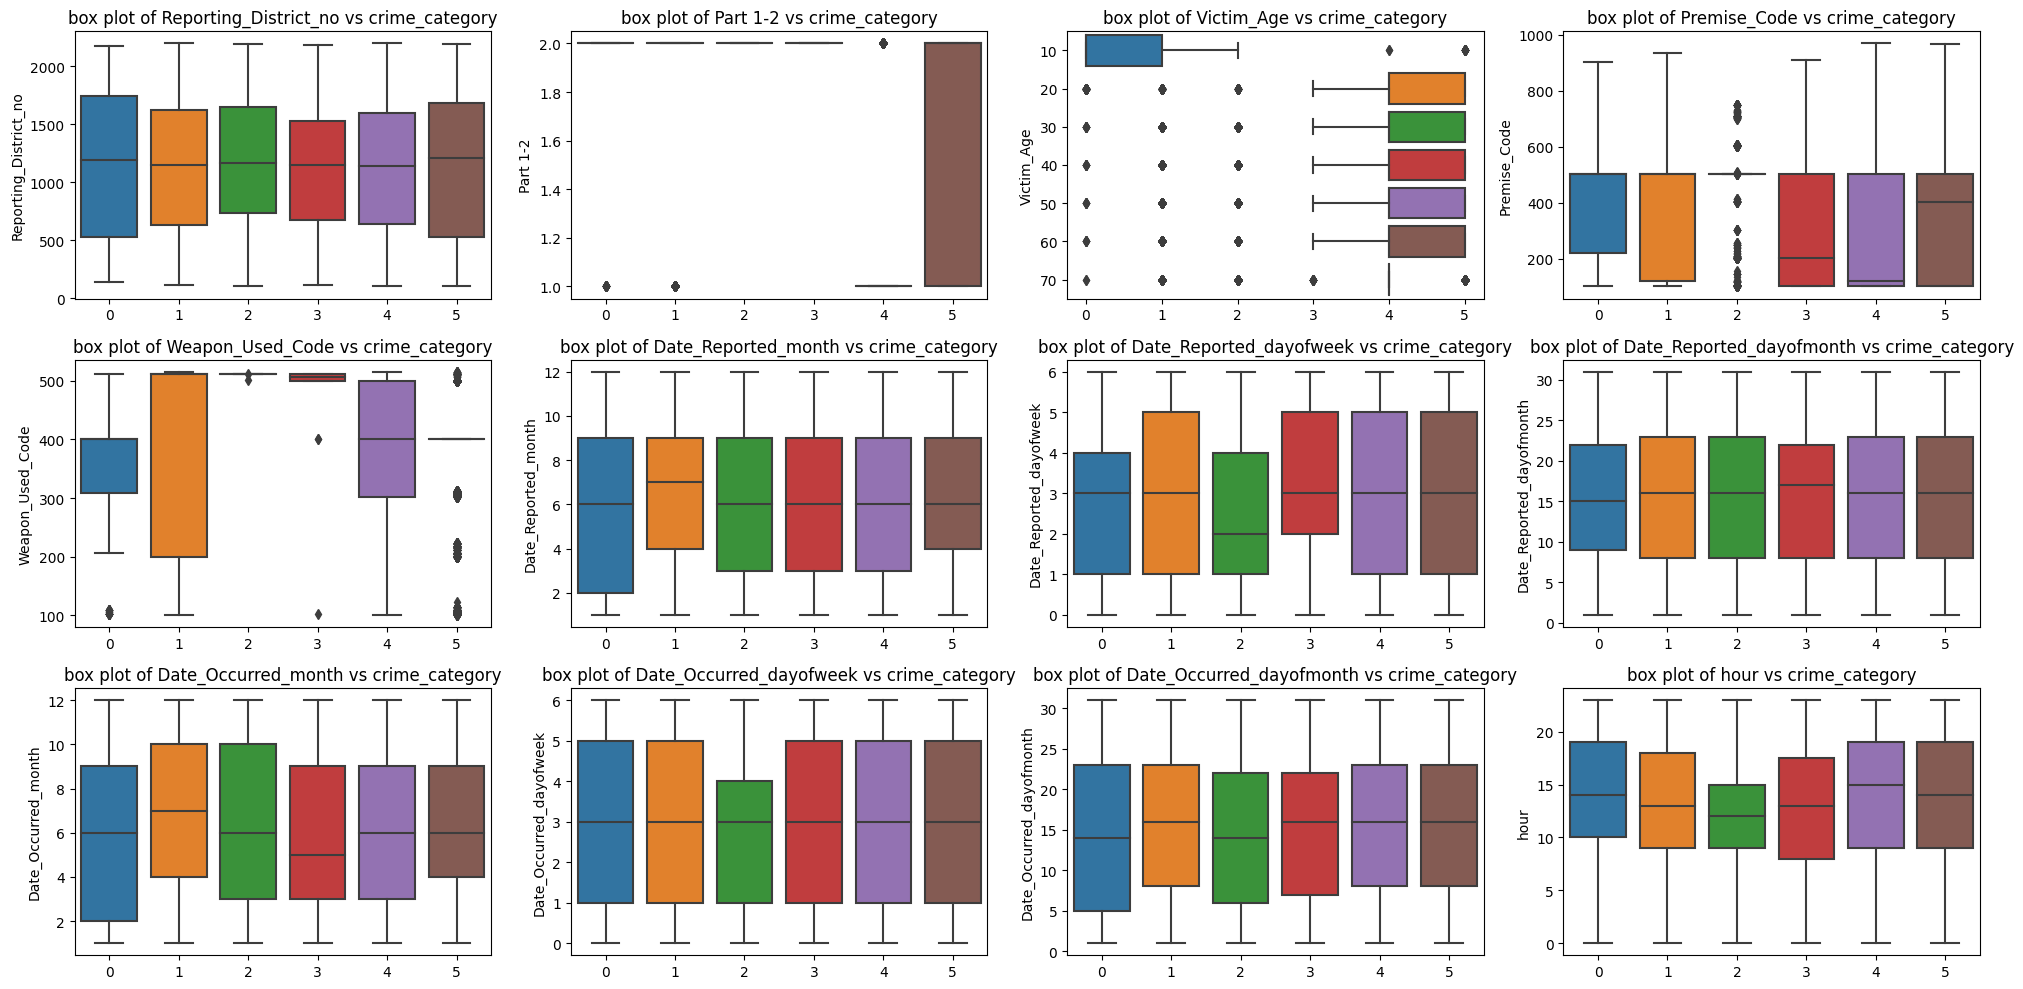

In [37]:
plt.figure(figsize=(20, 10))

columns = num_cols.columns
num_cols_length = len(columns)
rows = (num_cols_length + 3) // 4  # Calculate rows needed with 4 plots per row

for i in range(num_cols_length):
    plt.subplot(rows, 4, i + 1)
    sns.boxplot(x=y, y=data[columns[i]], data=data)
    plt.title(f'box plot of {columns[i]} vs crime_category')

plt.tight_layout()
plt.show()


**Insights**:- 

various different kind of veapon used for 5 category of crime that is voilent crimes

# Splitting the data

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)
X_train.shape,X_test.shape

((16000, 18), (4000, 18))

# Preprocessing

In [30]:
X_clean.columns

Index(['Reporting_District_no', 'Part 1-2', 'Victim_Age', 'Premise_Code',
       'Weapon_Used_Code', 'Date_Reported_month', 'Date_Reported_dayofweek',
       'Date_Reported_dayofmonth', 'Date_Occurred_month',
       'Date_Occurred_dayofweek', 'Date_Occurred_dayofmonth', 'hour',
       'Location', 'Area_Name', 'Modus_Operandi', 'Victim_Sex',
       'Victim_Descent', 'Status_Description'],
      dtype='object')

In [31]:
num_columns=['Reporting_District_no','Victim_Age','Date_Reported_month', 'Date_Reported_dayofweek', 'Date_Reported_dayofmonth', 'Date_Occurred_month',
       'Date_Occurred_dayofweek', 'Date_Occurred_dayofmonth','hour']
cat_one_hot_columns=['Status_Description','Part 1-2','Victim_Sex','Victim_Descent','Area_Name','Premise_Code','Weapon_Used_Code','Location']
text='Modus_Operandi'


In [32]:
X['Location'].value_counts()

Location
ST           6581
AV           5748
BL           3724
DR            783
PL            563
             ... 
PASADENA        1
117TH           1
CLOVER          1
HYPERION        1
INGLEWOOD       1
Name: count, Length: 642, dtype: int64

1. One hot encoding on categorical data- helps in converting catgorical feature in numerical and make category of each feature.
2. Modus_Operandi this is a text column so we can use tfidf or count vectorizor 
3. Standard scaling makes the feature with zero mean and unit varience


In [33]:
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


In [34]:
num_pipeline = Pipeline([('scale',StandardScaler())])
cat_pipeline = Pipeline([('onehot',OneHotEncoder(handle_unknown='ignore'))])
text_pipeline = Pipeline([('vect',TfidfVectorizer())])

In [35]:
Transformer1 = ColumnTransformer([('num_pipe',num_pipeline,num_columns),('cat_pipe',cat_pipeline,cat_one_hot_columns)])
Transformer2 = ColumnTransformer([('text_pipe',text_pipeline,text)])

In [36]:
union = FeatureUnion([('transformer1',Transformer1),('transformer2',Transformer2)])

In [37]:
X_train_transformed = union.fit_transform(X_train)
X_test_transformed = union.transform(X_test)

In [38]:
X_train_transformed

<16000x1343 sparse matrix of type '<class 'numpy.float64'>'
	with 323632 stored elements in Compressed Sparse Row format>

# Features-decomposition/selection

I used different decomposition technique.

* SVD decomposes the data matrix into three other matrices (U, Σ, and V). It's more general and can be applied directly to any matrix
* SelectKBest selects the top k features based on a statistical test. It's a filter-based method that doesn't transform the data but rather selects the most relevant features.
* PCA reduces dimensionality by finding new uncorrelated variables (principal components) that maximize the variance in the data.
* PCA gives very bad result hence remove it.

**SVD- Singular Value Decomosition**

In [39]:
from sklearn.decomposition import TruncatedSVD

In [40]:
svd = TruncatedSVD(n_components = 200)
X_train_reduced = svd.fit_transform(X_train_transformed)
X_test_reduced = svd.transform(X_test_transformed)

In [41]:
X_train_reduced.shape

(16000, 200)

In [42]:
X_train_final = pd.DataFrame(X_train_reduced)
X_test_final = pd.DataFrame(X_test_reduced)

**skb- Select k Best**

In [43]:
from sklearn.feature_selection import SelectKBest, f_regression,f_classif
selector = SelectKBest(score_func = f_classif, k=200) #f_classif use for classification problem

In [44]:
X_train_selected = selector.fit_transform(X_train_transformed, y_train)
X_test_selected = selector.transform(X_test_transformed)

In [45]:
X_train_selected

<16000x200 sparse matrix of type '<class 'numpy.float64'>'
	with 186127 stored elements in Compressed Sparse Row format>

In [46]:
X_train_final_s = pd.DataFrame(X_train_selected.toarray())
X_test_final_s = pd.DataFrame(X_test_selected.toarray())

**MODEL TRAINING**

Trying decomposition on different models to see which one perform better.

Logistic regression -classify data based on sigmoid score 

* LogisticRegression with svd

In [49]:
from sklearn.linear_model import LogisticRegression

In [59]:
lg = LogisticRegression(random_state = 42, max_iter = 1000)
lg.fit(X_train_final, y_train)
y_pred_svd = lg.predict(X_test_final)

In [60]:
accuracy_score(y_test, y_pred_svd)

0.943

* logistic_regression_with_select_k_best

In [61]:
lg = LogisticRegression(random_state = 42, max_iter = 1000)
lg.fit(X_train_final_s, y_train)
y_pred_svd = lg.predict(X_test_final_s)

In [62]:
accuracy_score(y_test, y_pred_svd)

0.94925

Select k best give 0.9455 which is greater then truncated svd that is 0.94375, thus we use select k best 

Recursive feature elimination gives better result but it is taking lot of time .

In [582]:
# model = XGBClassifier(random_state=42)  
# # Create the RFE object with Logistic Regression as the estimator
# rfe = RFE(estimator=model, n_features_to_select=150)  # Adjust n_features_to_select as needed

# # Fit the RFE object to the data
# X_train_rfe=rfe.fit_transform(X_train_final_s, y_train)
# y_pred_rfe=rfe.predict(X_test_final_s)




In [583]:
# accuracy_score(y_test, y_pred_rfe)

0.95425

score = 0.95425

#  Trying different models

**DecisionTreeClassifier**

Breakes the data into subsets based on the input feature and creates tree like structure

In [ ]:
from sklearn.tree import plot_tree,DecisionTreeClassifier

In [ ]:
dtc = DecisionTreeClassifier(random_state = 42)

In [ ]:
dtc.fit(X_train_final_s, y_train)
y_pred_dtc = dtc.predict(X_test_final_s)

In [ ]:
accuracy_score(y_test, y_pred_dtc)

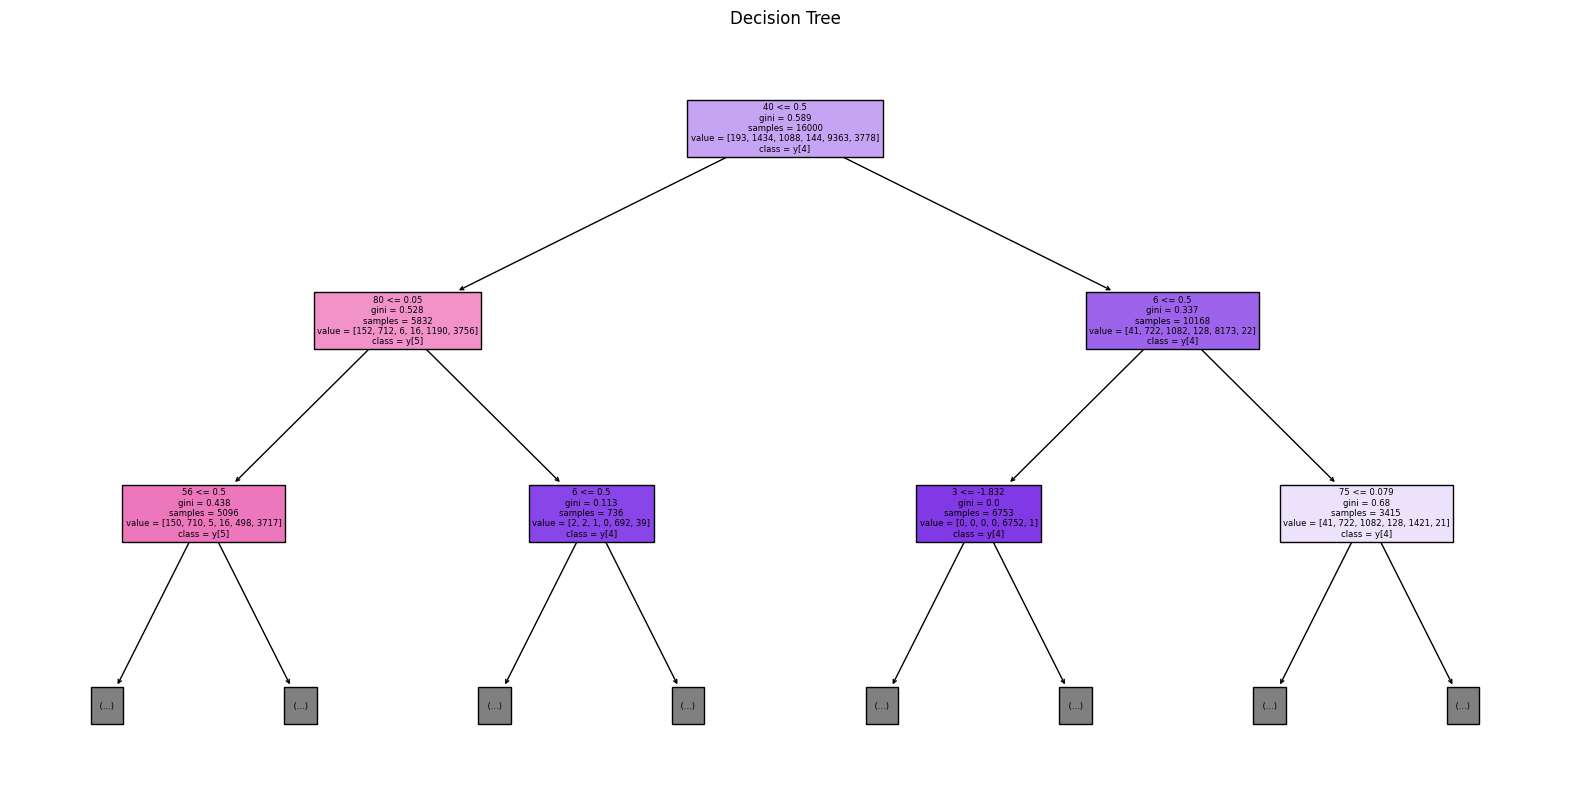

In [570]:
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
plot_tree(dtc, filled=True, feature_names=X_train_final_s.columns, class_names=True,max_depth=2)  # Adjust class names as needed
plt.title('Decision Tree')
plt.show()

score= 0.9287

**Model Pipeline with different models**

LGBMClassifier and XGBClassifier is a boosting technique ,MLP classifier works on neural networks concept,svc works by seperating data with hyperplane with maximum margins

In [47]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier 
# from sklearn.naive_bayes import MultinomialNB I tried it but not giving good result
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report,roc_curve, auc, PrecisionRecallDisplay,precision_recall_curve



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8672
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 159
[LightGBM] [Info] Start training from score -4.417654
[LightGBM] [Info] Start training from score -2.412121
[LightGBM] [Info] Start training from score -2.688248
[LightGBM] [Info] Start training from score -4.710531
[LightGBM] [Info] Start training from score -0.535823
[LightGBM] [Info] Start training from score -1.443394


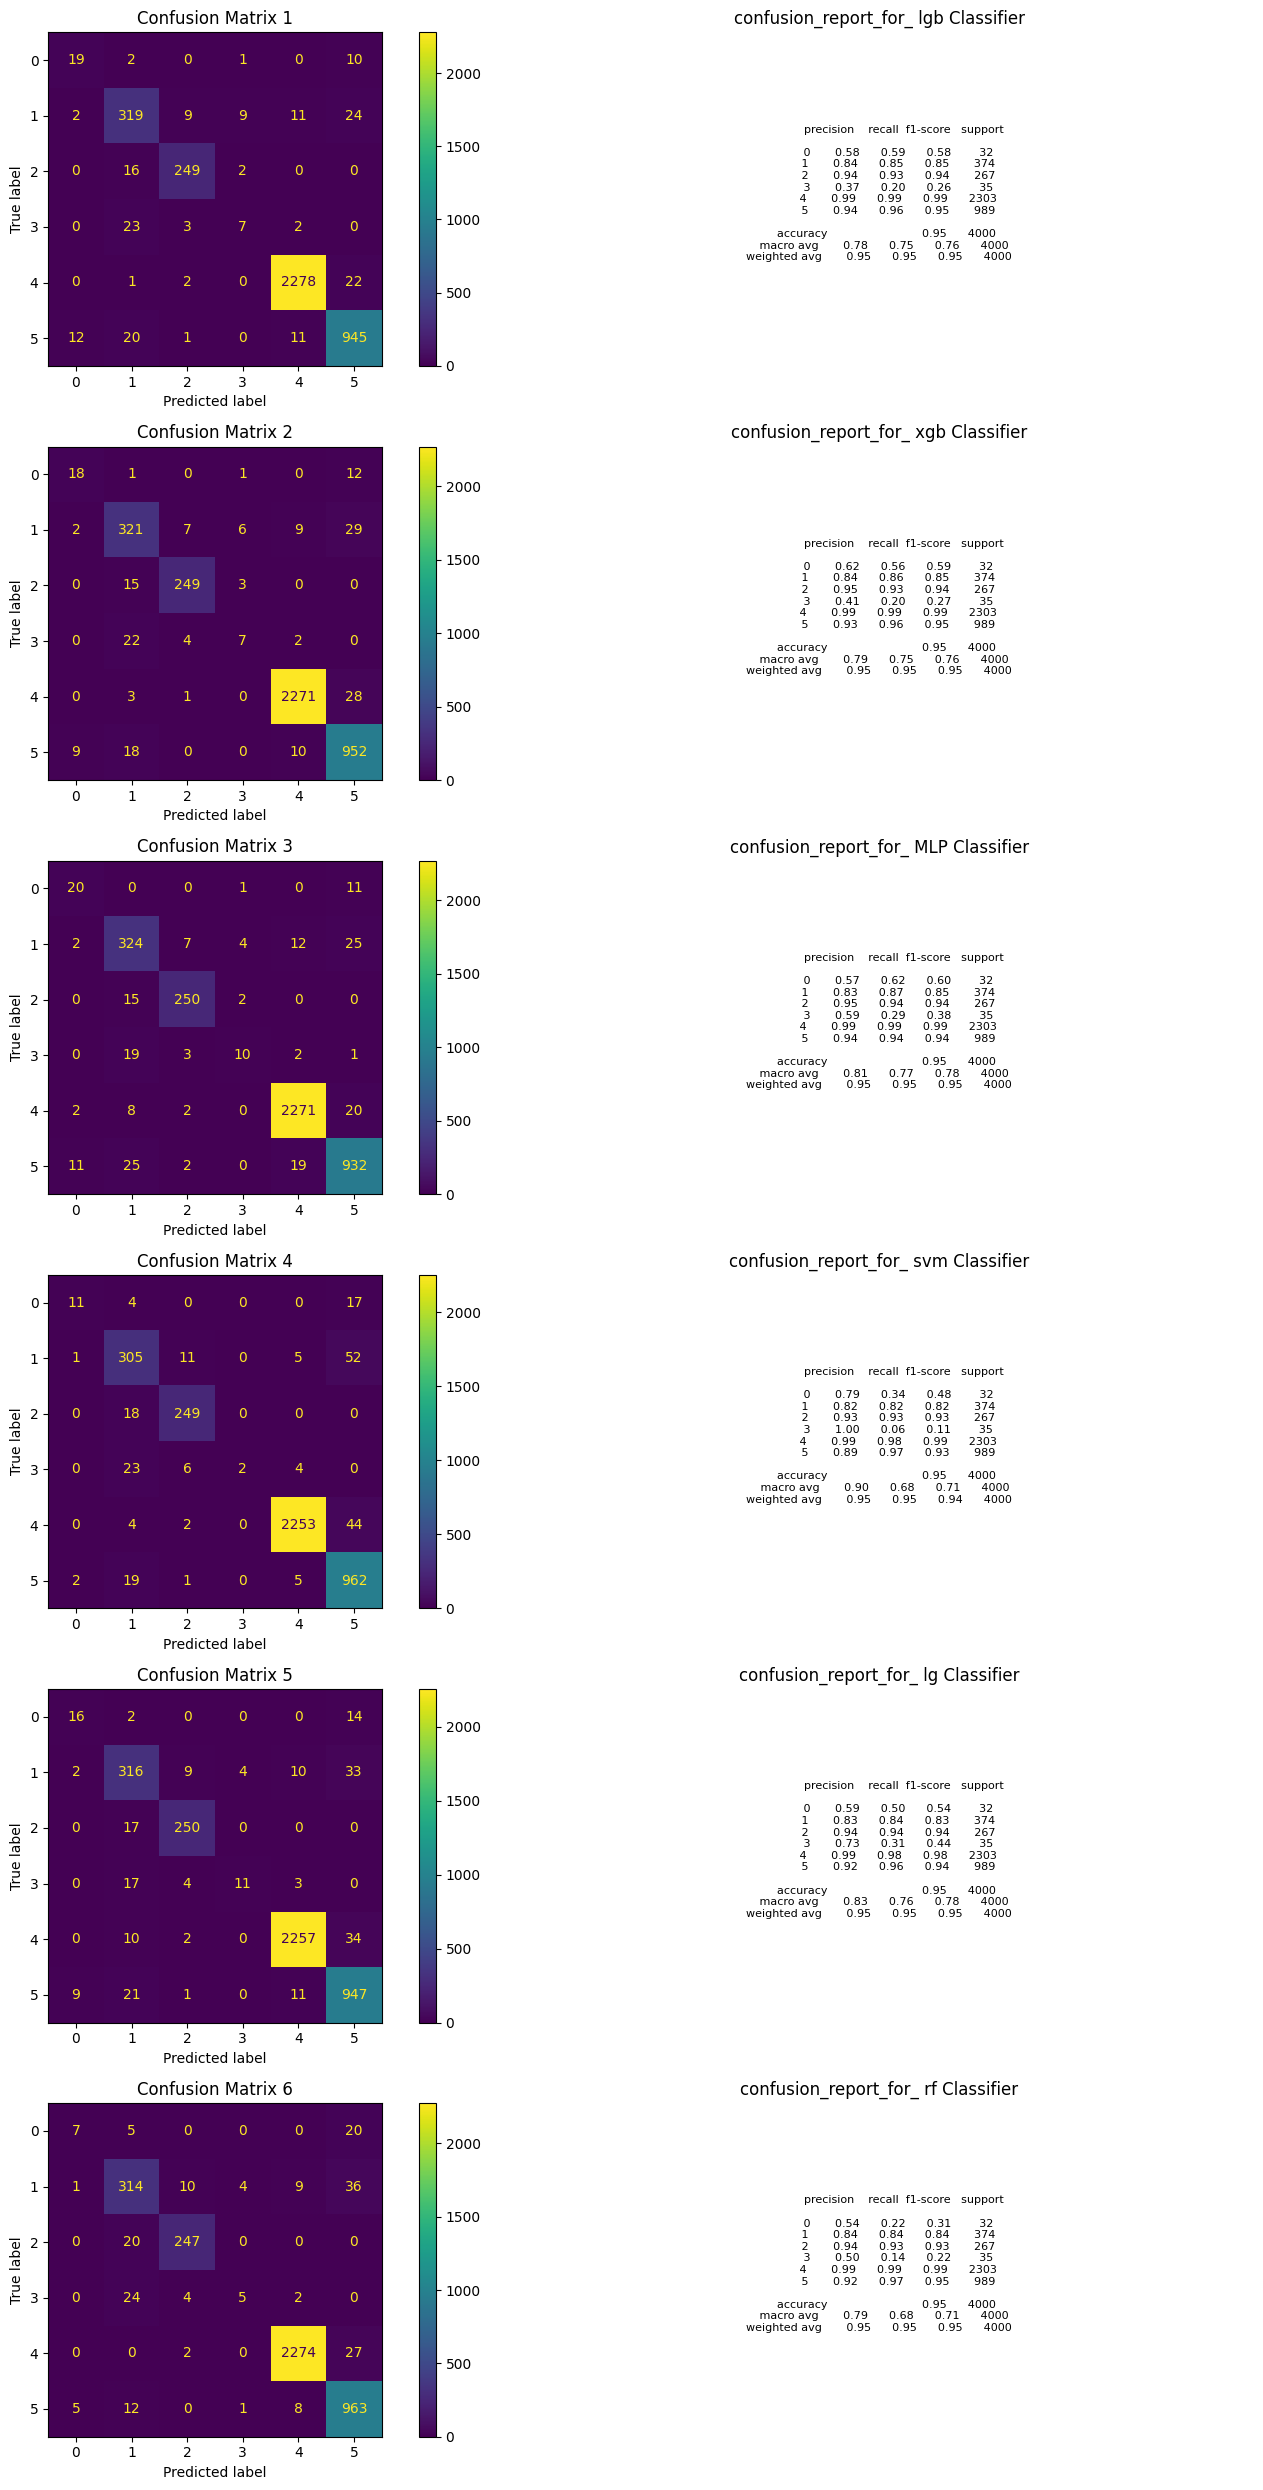

{'lgb': 0.95425, 'xgb': 0.9545, 'MLP': 0.95175, 'svm': 0.9455, 'lg': 0.94925, 'rf': 0.9525}


In [51]:
models = {
    'lgb': LGBMClassifier(random_state=42),
    'xgb': XGBClassifier(random_state=42),
    'MLP': MLPClassifier(),
    'svm': SVC(),
    'lg': LogisticRegression(random_state = 42, max_iter = 1000),
    'rf': RandomForestClassifier(random_state = 42)
    
}

score = {}
y_pred={}
i=0
fig, axes = plt.subplots(len(models), 2, figsize=(15, 5 * 5))
for k,v in models.items():
#     model pipeline 
    model_pipeline = Pipeline([('preprocessing',union),('feature_selection',SelectKBest(score_func = f_classif, k=200)),('model',v)])
    model_pipeline.fit(X_train,y_train)
#     storing score of each model
    score[k] = model_pipeline.score(X_test,y_test)
#     y prediction for each model
    y_pred=model_pipeline.predict(X_test)
#     confusion matrix for each model
    cm=confusion_matrix(y_test,y_pred)
    ax_cm=axes[i,0]
    confusion_display=ConfusionMatrixDisplay(confusion_matrix=cm)
    confusion_display.plot(ax=ax_cm)
    ax_cm.set_title(f"Confusion Matrix {i+1}")
#   classification report for each model
    ax_report=axes[i,1]
    ax_report.axis("off")
#     text is centered and frame is also centered
    ax_report.text(0.5,0.5,classification_report(y_test,y_pred),va='center',ha='center',fontsize=8)
    
    title=f"confusion_report_for_ {k} Classifier"
    
    ax_report.set_title(title)


    i += 1  # Increment index manually
    fig.tight_layout()
plt.show()
print(score)

**Scores dict**

{'lgb': 0.95425, 'xgb': 0.9545, 'MLP': 0.948, 'svm': 0.9455, 'lg': 0.94925, 'rf': 0.9525}

Insights 

* Models are predicting class 4 mostly very well due to its large samples size
* class 0 and 3 predicts too badly
* from the above above model xgb performs best in terms of accuracy.
* LGBM and MlP classifier performs best in terms of ROC_AUC curve as they have highest area under the curve ie 0.42.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8672
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 159
[LightGBM] [Info] Start training from score -4.417654
[LightGBM] [Info] Start training from score -2.412121
[LightGBM] [Info] Start training from score -2.688248
[LightGBM] [Info] Start training from score -4.710531
[LightGBM] [Info] Start training from score -0.535823
[LightGBM] [Info] Start training from score -1.443394


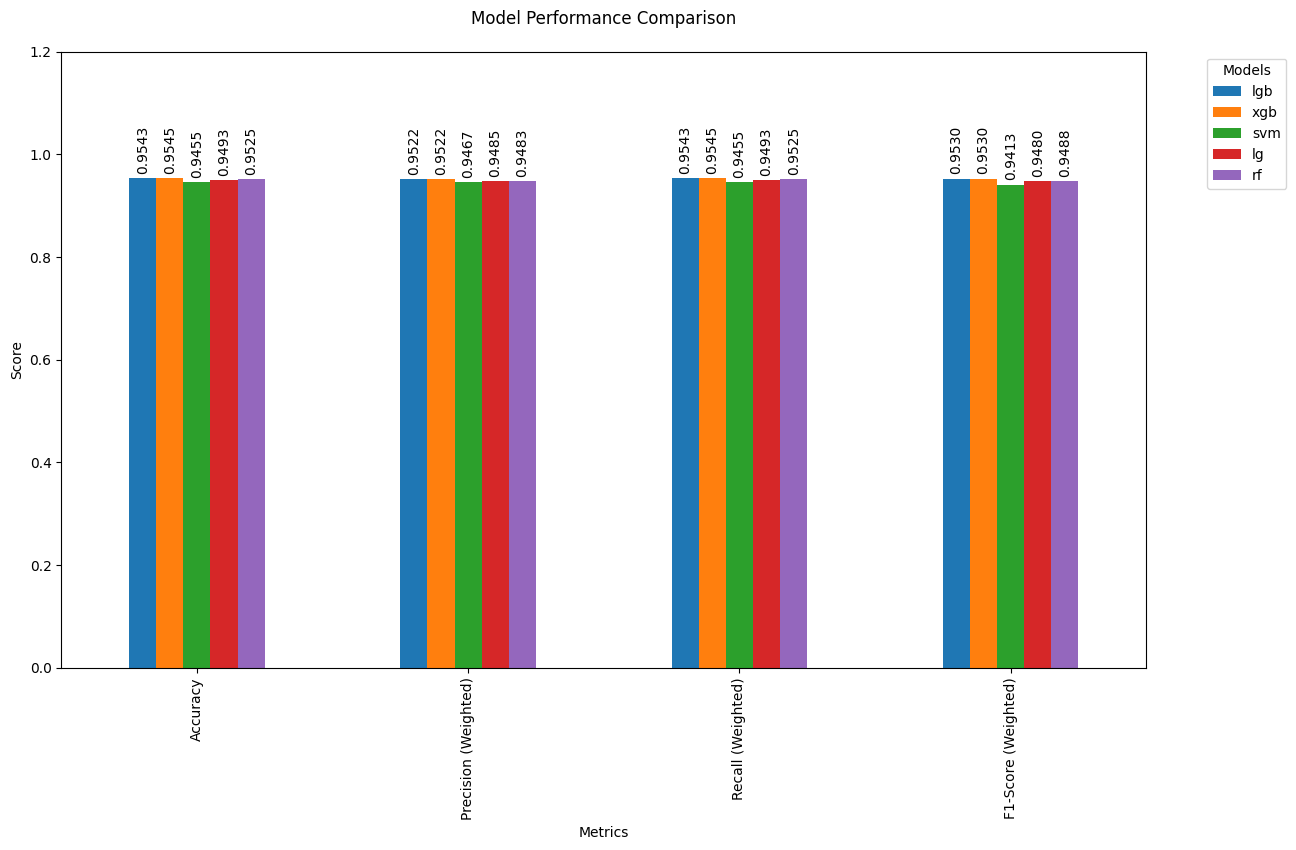

       Accuracy  Precision (Weighted)  Recall (Weighted)  F1-Score (Weighted)
Model                                                                        
lgb     0.95425              0.952237            0.95425             0.953007
xgb     0.95450              0.952248            0.95450             0.952966
svm     0.94550              0.946732            0.94550             0.941308
lg      0.94925              0.948496            0.94925             0.947997
rf      0.95250              0.948273            0.95250             0.948788


In [70]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Example dictionary of models
models = {
    'lgb': LGBMClassifier(random_state=42),
    'xgb': XGBClassifier(random_state=42),
    'svm': SVC(),
    'lg': LogisticRegression(random_state = 42, max_iter = 1000),
    'rf': RandomForestClassifier(random_state = 42)
    
}

# Initialize an empty list to store metrics
metrics_list = []

# Loop through each model in the dictionary
for model_name, model in models.items():
    # Make predictions
    model_pipeline = Pipeline([('preprocessing',union),('feature_selection',SelectKBest(score_func = f_classif, k=200)),('model',model)])
    model_pipeline.fit(X_train,y_train)
    score[k] = model_pipeline.score(X_test,y_test)
    y_pred=model_pipeline.predict(X_test)
    
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')#average of all classes
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
  
    # Append metrics to the list
    metrics_list.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision (Weighted)': precision,
        'Recall (Weighted)': recall,
        'F1-Score (Weighted)': f1
    })

# Convert the list of metrics into a DataFrame
metrics_df = pd.DataFrame(metrics_list)

metrics_df.set_index('Model', inplace=True)

# Transpose the DataFrame to have metrics as columns
metrics_transposed = metrics_df.transpose()

# Plot the grouped bar chart
ax = metrics_transposed.plot(kind='bar', figsize=(14, 8))
plt.title('Model Performance Comparison',pad=20)
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.ylim(0, 1.2)  # Assuming scores range between 0 and 1
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')


    
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                rotation=90, 
                xytext=(0, 3), 
                textcoords='offset points')#making labels above bar by relatively setting position

plt.show()

# Display the DataFrame
print(metrics_df)


* LGBM and XGB performs well and are very close in every metrics 
* In terms of recall XGB wins by 0.0002 and in accuracy as well 
* In terms of F1 score LGBM perform well .
* Here it seems XGB Perform well but while submitting LGBM score is higher on the unseen data

  

**HPT**

First I tried with grid search cv but it is taking to long and not providing optimal result thus I switch to randomized search cv as it takes thing random and are much faster.

randomized search performs better on large data

In [72]:
from sklearn.model_selection import RandomizedSearchCV

In [73]:
C_values = [0.1,0.125]
lr_param={
    'penalty':['l1','l2'],       #l1=ridge,l2=lasso
    'C': C_values,                # Opposite of regularisation lower c value higher regularisation lesser overfitting
    "solver":['lbfgs','saga','liblinear']  #saga for bigger data ,libliner works well with small ,lgfgs works well with medium size
}
    
random_search_lr = RandomizedSearchCV(lg,param_distributions=lr_param,cv=3,n_jobs=-1,verbose=1)
random_search_lr.fit(X_train_final,y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(max_iter=1000, random_state=42),
                   n_jobs=-1,
                   param_distributions={'C': [0.1, 0.125],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['lbfgs', 'saga',
                                                   'liblinear']},
                   verbose=1)

In [74]:
random_search_lr.best_params_

{'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.125}

{'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.125}

In [75]:
random_search_lr.best_score_

0.9285000775615592

0.929062554129918 is the score after hyperparameter

**xgb**

In [ ]:

# from sklearn.metrics import accuracy_score

# # Define the model
# xgb_model = XGBClassifier()

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [50, 100],         #n_estimators: The number of trees in the ensemble.
                                            #learning_rate: Also known as eta, controls the step size at each boosting iteration. 
                                            #max_depth: The maximum depth of each tree. 
                                            #min_child_weight: The minimum sum of instance weight (hessian) needed in a child node.
#     'learning_rate': [0.1, 0.2],
#     'max_depth': [3, 4],
#     'min_child_weight': [1, 2],
   
# }

# # Set up the GridSearchCV object
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)#3-fold cross validation model divides data into three parts and one part treated as train data and other two as validation.

# # Fit the model
# grid_search.fit(X_train_final_s, y_train)


In [ ]:
# best_param = grid_search.best_params_
# best_param

best_param-{'learning_rate': 0.2,
 'max_depth': 4,
 'min_child_weight': 2,
 'n_estimators': 100}

In [ ]:
# best_scores = grid_search.best_score_
# best_scores

best_scores
0.9512500933633062

In [ ]:
# from sklearn.metrics import accuracy_score

# # Load your data
# # X_train, X_test, y_train, y_test should be defined before

# # Define the model
# xgb_model = XGBClassifier()

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100,125],
#     'learning_rate': [0.05,0.1, 0.15],
#     'max_depth': [5],
#     'min_child_weight': [1, 1.5],
   
# }

# # Set up the GridSearchCV object
# grid_search_xgb2 = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)#n_jobs=1 performing cpu task parallely

# # Fit the model
# grid_search_xgb2.fit(X_train_final, y_train)

In [ ]:
# best_scores_xgb = grid_search.best_score_
# best_scores_xgb

0.9512500933633062 scoresare notimproving


**Model Training and Evaluation**

In [572]:
final_pipeline = Pipeline([('preprocessing',union),('feature_selection',SelectKBest(score_func = f_classif, k=200)),('model',LGBMClassifier(random_state=42))])
final_pipeline.fit(X_train,y_train)
y_pred = final_pipeline.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8672
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 159
[LightGBM] [Info] Start training from score -4.417654
[LightGBM] [Info] Start training from score -2.412121
[LightGBM] [Info] Start training from score -2.688248
[LightGBM] [Info] Start training from score -4.710531
[LightGBM] [Info] Start training from score -0.535823
[LightGBM] [Info] Start training from score -1.443394


In [573]:
accuracy = final_pipeline.score(X_test,y_test)
accuracy

0.95425

# Submission

In [126]:
test_data = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')

In [127]:
test_data.describe()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,1847.000000
mean,33.957169,-117.952663,1337.737400,10.736600,1119.879800,1.414000,30.592000,300.858800,364.014077
std,1.986742,6.890957,663.922202,6.051524,605.143645,0.492598,21.897905,212.253742,119.489932
min,0.000000,-118.650300,1.000000,1.000000,101.000000,1.000000,-2.000000,101.000000,101.000000
25%,34.010800,-118.431200,900.000000,6.000000,628.000000,1.000000,14.000000,101.000000,309.000000
50%,34.058000,-118.323200,1430.000000,11.000000,1138.000000,1.000000,31.000000,203.000000,400.000000
75%,34.162250,-118.274600,1900.000000,16.000000,1622.250000,2.000000,46.000000,501.000000,400.000000
max,34.327500,0.000000,2359.000000,21.000000,2197.000000,2.000000,99.000000,957.000000,516.000000


In [128]:
test_data['Victim_Age'].replace(-2,0,inplace=True)#replacing -2 to handel missing value

# Conversion of feature date_Occurred,Time_Ocurred and date_reported to month,week and hour on test data

In [ ]:
def process_dates_t(data_e,date_column):
    test_data[date_column]= pd.to_datetime(test_data[date_column])
    test_data[f'{date_column}_month'] = test_data[date_column].dt.month
    test_data[f'{date_column}_dayofweek'] = test_data[date_column].dt.dayofweek
    test_data[f'{date_column}_dayofmonth'] = test_data[date_column].dt.day
    return test_data

In [ ]:
test_data = process_dates_t(test_data, 'Date_Reported')

In [ ]:
test_data.drop(columns=['Date_Reported'],inplace=True)

In [ ]:
test_data = process_dates_t(test_data, 'Date_Occurred')

In [ ]:
test_data.drop(columns=['Date_Occurred'],inplace=True)

In [ ]:
test_data

In [ ]:
dtt=pd.DataFrame()
dtt

In [ ]:
dtt['Time_Occurred']=test_data['Time_Occurred'].copy()
dtt['hour']=(dtt['Time_Occurred'].apply(convertingtohour))
dtt=dtt.drop(columns=['Time_Occurred'])
dtt

In [ ]:
test_data.drop(columns=['Time_Occurred'],inplace=True)

In [ ]:
test_data = pd.concat([test_data,dtt],axis=1)

In [ ]:
test_data['hour'].replace('',0,inplace=True)

In [ ]:
test_data['hour']=test_data['hour'].astype(int)

In [ ]:
test_data['Location'].apply(extract_last_word)#extracting last word of location

In [ ]:
test_data['Victim_Age']=pd.cut(test_data['Victim_Age'],bins=(0,10,20,30,40,50,60,float('inf')),labels=['10','20','30','40','50','60','70'])#binning victim_age

# Droping some column

In [ ]:

X_test = test_data.drop(columns=['Premise_Description','Status','Latitude','Longitude','Area_ID','Cross_Street','Weapon_Description'])

# Imputation

In [ ]:
cat_cols_test=X_test.select_dtypes(include='object')
num_cols_test=X_test.select_dtypes(exclude='object')

In [ ]:
transform2=ColumnTransformer([('num_cols',SimpleImputer(missing_values=np.nan,strategy='0'),num_cols_test.columns),
                            ('cat_cols',SimpleImputer(missing_values=np.nan,strategy='v_null'),cat_cols_test.columns)],verbose_feature_names_out=False).set_output(transform=('pandas'))
transform.fit_transform(X_clean,y)
X_test_clean=transform.transform(X_test)

In [ ]:
final_pipeline.fit(X_clean,y) # Lowering the bias

In [ ]:
predictions = final_pipeline.predict(X_test_clean)


In [ ]:
y_pred = lencoder.inverse_transform(predictions)

In [ ]:
submission_df = pd.DataFrame({
    'ID': range(1, len(y_pred) + 1),  # Using index as ID
    'Crime_Category': y_pred
})

In [ ]:
# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

# Thankyou